# Классификация изображений Симпсонов



# Импорты и подготовка данных

In [1]:
import torch
import numpy as np
import PIL
import time
from tqdm.autonotebook import tqdm, trange

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/



Ниже мы исспользуем враппер над датасетом для удобной работы.

In [7]:
# Немного кастомизировал Dataset, добавил туда аугментации


class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, augmentation):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.augmentation = augmentation

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        self.augmentation_transform = transforms.Compose([transforms.ToPILImage(),
                                                          # transforms.RandomCrop((50,50))
                                                          transforms.RandomHorizontalFlip(p=1)
                                                          ])
        self.norm_transform = transform = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                        ])

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image.copy()
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        if self.augmentation:
            x = self.augmentation_transform(x)
      
        x = np.array(np.array(x) / 255, dtype='float32')
        x = self.norm_transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)


In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
# Посмотрим количество классов в датасете
number_of_simpson_classes = len(np.unique(train_val_labels))
number_of_simpson_classes

42

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val',augmentation=False)

In [13]:
len(val_files), len(train_files)

(5234, 15699)

In [14]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset_orig = SimpsonsDataset(train_files, mode='train',augmentation=False)
train_dataset_aug = SimpsonsDataset(train_files, mode='train',augmentation=True)

Давайте посмотрим на наших героев внутри датасета.

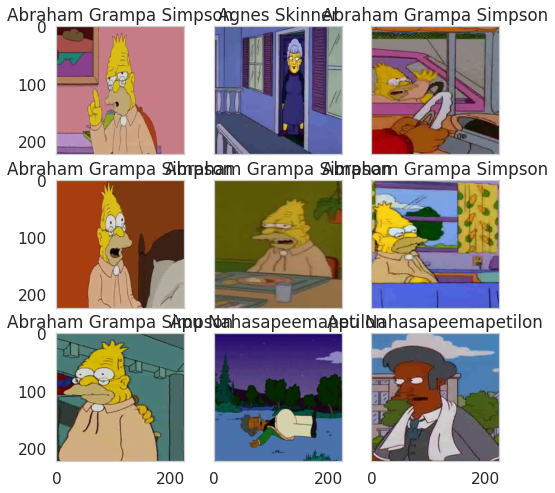

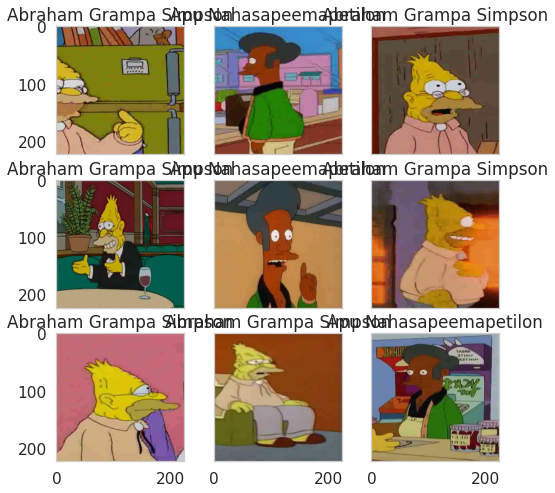

In [15]:
np.random.seed(0)

def show(dataset):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                          sharey=True, sharex=True)

    for fig_x in ax.flatten():
        random_characters = int(
                    np.random.uniform(0,1000))
        img, label = dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    dataset.label_encoder.inverse_transform([label])[0].split('_')))
        imshow(img.data.cpu(), \
              title=img_label,plt_ax=fig_x)

show(train_dataset_orig)
show(train_dataset_aug)

Глянем на балланс классов и на то, является ли тестовая выборка репрезентативной

In [19]:
import pandas as pd
from collections import Counter

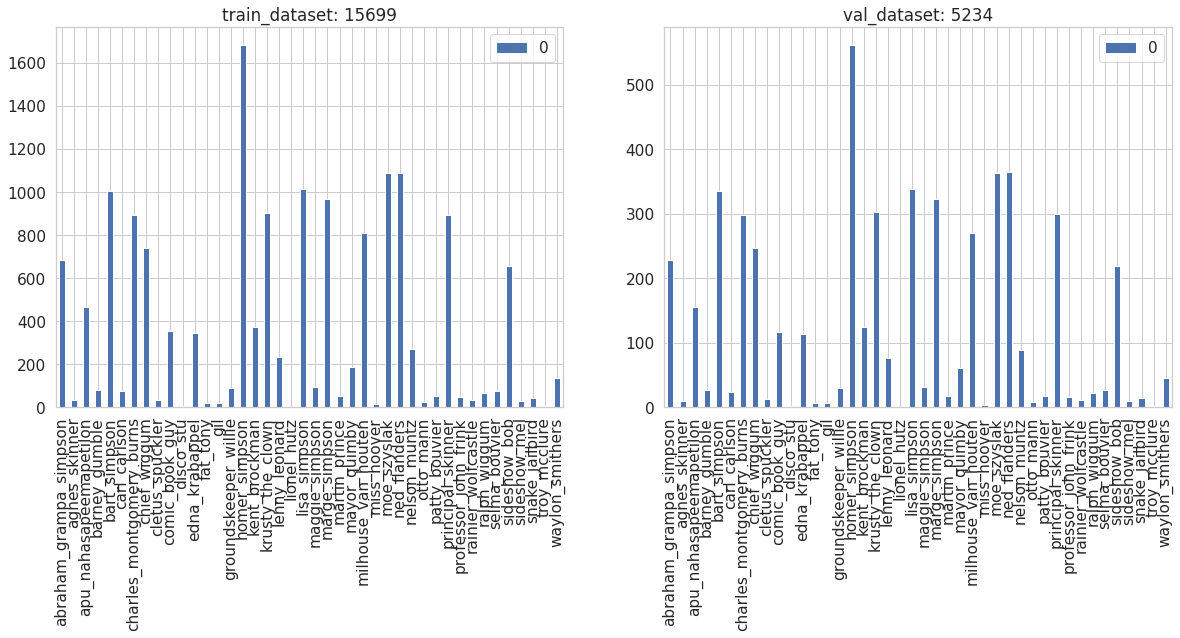

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 7))

for ax, dataset in zip(axes, [train_dataset_orig, val_dataset]):
  label_counts = Counter(dataset.labels)
  df = pd.DataFrame.from_dict(label_counts, orient='index')
  df.plot(kind='bar', ax=ax)
  ax.set_title(f"train_dataset: {len(train_dataset_orig)}" if dataset==train_dataset_orig else f"val_dataset: {len(val_dataset)}")

Ну вроде ве похоже, выборки репрезентативны

# Строим модель

In [24]:
# взял трейн-функцию с последнего семинара, скрестил ее с тем, что было в бейзлайне с заданием
№ и добавил аугментацию

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, batch_size=64):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()


            # итерируемся по датасетам исходным и аугментированным в трейн
            dataset_scope = [train_dataset_orig, train_dataset_aug] if phase == 'train' else [val_dataset]

            for dataset in dataset_scope:
                running_loss = 0.0
                running_corrects = 0
                processed_data = 0

                if dataset == train_dataset_orig:
                    print("train orig")
                if dataset == train_dataset_aug:
                    print("train aug")

                for data in tqdm(DataLoader(dataset, batch_size=batch_size, shuffle=True),\
                                leave=False, desc=f"{phase} iter:"):
                    # получаем картинки и метки
                    inputs, labels = data

                    # оборачиваем в переменные
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    else:
                        inputs, labels = inputs, labels

                    # инициализируем градиенты параметров
                    if phase=="train":
                        optimizer.zero_grad()

                    # forward pass
                    if phase == "eval":
                        with torch.no_grad():
                            outputs = model(inputs)
                    else:
                        outputs = model(inputs)
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)

                    # backward pass + оптимизируем только если это стадия обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # статистика
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += int(torch.sum(preds == labels.data))
                    processed_data += inputs.size(0)

                epoch_loss = running_loss / processed_data
                epoch_acc = running_corrects / processed_data

                losses[phase].append(epoch_loss)
                print("phase: ", phase, " acc: ", epoch_acc)
                pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                        phase, epoch_loss, epoch_acc
                                    ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [22]:
from torchvision import models

# VGG

In [23]:
# решил именно тюнить, потому что при решении реальных задач вряд-ли придется на начальных
# этапах придумывать свои архитектуры. Ну и на решении тестовой задачи на собесе я один раз
# пытался тюнить, но неудачно. Захотелось отыграться.
# Тюнить решил vgg_bn т.к. в коментах на степике ее рекомендовали для отладки.
# Результат моего тюна вышел несколько лучше, чем у парня на степике (~0.86),
# даже без балланса классов, что было приятным сюрпризом.

# В чате писали, что vgg - самая неклюжая архитектура и лучше юзать inception_v3, efficient и тд.
# Сначала хотел попробовать с разными моделями и найти лучшую, но чет лень.

# З.Ы. если выбрать другой model_extractor, то все должно воспроизвестись с efficient, думаю

model_extractor = models.vgg16_bn(pretrained=True)

layers_to_unsqueeze = 15
# замораживаем параметры до 15 слоя. Почему до 15? методом тыка
# испробовал много вариантов, но сюда добавлять не стал.
# Вообще сначала ловил лютые переобучения. На трейне до 0.99 быстро доходил, а на вале - 0.45 максимум
# 3 дня не мог понять че делать, думал проблема с архитектурой, что подтверждали в чате
# Но нет, баг был в трейн методе. Выяснилось после того как я вставил SimpleCNN и он своих 0.6 не дал
# P.S. если сначала идет переобучение, смотрите внимательно на баги в коде))
for param in model_extractor.features[:-layers_to_unsqueeze].parameters():
    param.requires_grad = False

In [34]:
num_features = 4096
# Дефотный классификатор на наш линейный классификатор
model_extractor.classifier[-1] = nn.Linear(num_features, number_of_simpson_classes)

# Использовать ли GPU
if train_on_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = torch.optim.Adam(model_extractor.parameters())

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [29]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [31]:
for param in model_extractor.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [35]:
# учим
model, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=14, batch_size=128)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
train iter::   0%|          | 0/123 [00:00<?, ?it/s]

train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.7428498630486018
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9039429263010382


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9040886511272449
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9338174406013122
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9476399770686031


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9254871990829193
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9577680107013186
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9680871393082362


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9165074512800917
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9688515192050449
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.973310401936429


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.942300343905235
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9752850500031849
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9730556086374929


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9361864730607566
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9826740556723358
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9835658322186126


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9514711501719526
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9924198993566469
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9952863239696796


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.957776079480321
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9975794636601057
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9987260335053189


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9610240733664501
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9984712402063826
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.998980826804255


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9610240733664501
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.998917128479521
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9988534301547869


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9619793656858999
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9992993184279253
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9994267150773934


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9623614826136798
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9993630167526594
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9997452067010638


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.9623614826136798
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9997452067010638
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9996178100515957


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  val  acc:  0.96140619029423
train orig


train iter::   0%|          | 0/123 [00:00<?, ?it/s]

phase:  train  acc:  0.9998089050257978
train aug


val iter::   0%|          | 0/41 [00:00<?, ?it/s]

phase:  train  acc:  0.9998089050257978


phase:  val  acc:  0.9623614826136798

Training complete in 166m 42s
Best val Acc: 0.962361


In [37]:
# сохраняем веса
torch.save(model.state_dict(), 'VGG_simpsons.pth')

In [38]:
model_extractor.load_state_dict(torch.load('VGG_simpsons.pth'))

<All keys matched successfully>

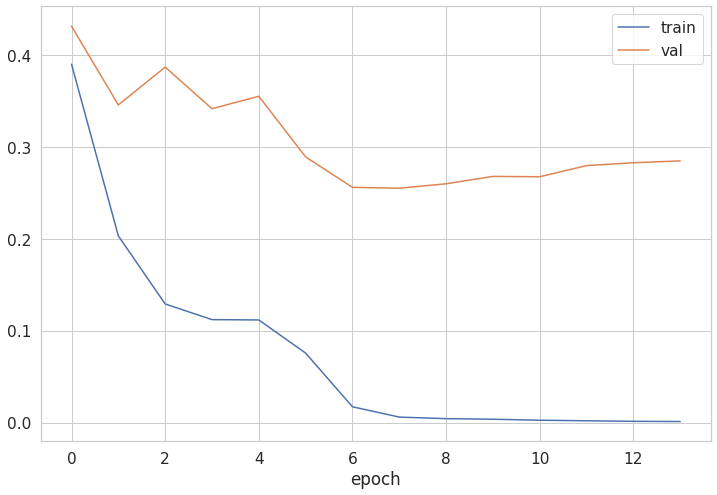

In [49]:
plt.figure(figsize=(12, 8))
plt.plot(losses['train'][1::2], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.xlabel("epoch")
plt.show()

# Peer review

In [50]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [69]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

# Предсказание, для одной картинки, если нужно
# probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

In [70]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

In [71]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [72]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Вычислим целевую метрику (f1) на валидационной выборке.

In [73]:
y_pred, len(y_pred)

(array([0, 6, 4, 6, 4, 4, 0, 2, 0, 2, 0, 2, 3, 0, 4, 4, 2, 4, 0, 4]), 20)

In [74]:
actual_labels, len(actual_labels)

([0, 6, 4, 6, 4, 4, 0, 2, 0, 2, 0, 2, 3, 0, 4, 4, 2, 4, 0, 4], 20)

In [75]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


1.0

### Submit на Kaggle

In [58]:
test_dataset = SimpsonsDataset(test_files, mode="test", augmentation=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [59]:
test_dataset

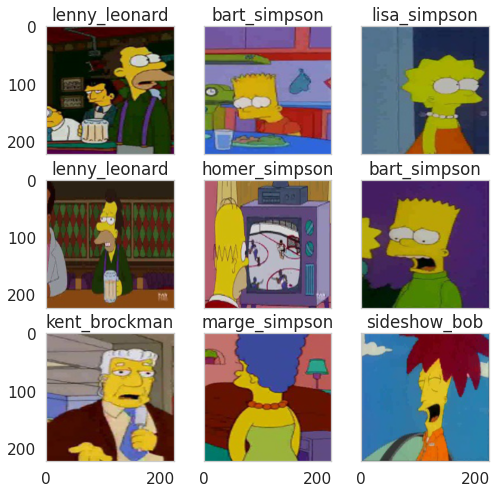

In [60]:
def show_test(dataset, preds):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                          sharey=True, sharex=True)

    for fig_x in ax.flatten():
        random_characters = int(
                    np.random.uniform(0,1000))
        img = dataset[random_characters]
        img_label = preds[random_characters]
        imshow(img.data.cpu(), title=img_label,plt_ax=fig_x)
        #imshow(img.data.cpu(), plt_ax=fig_x)

show_test(test_dataset, preds)

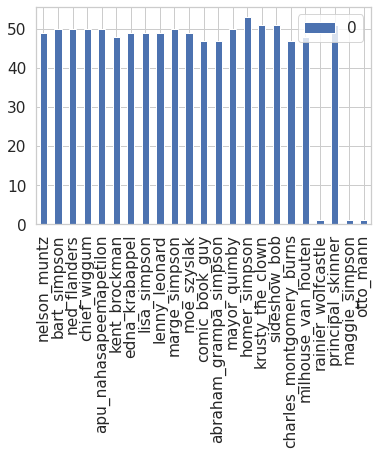

In [61]:
# ну глянем на распределение лейблов в тестовой выборке по преколу
label_counts = Counter(preds)
df = pd.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar')

In [62]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [65]:
my_submit.to_csv('vgg_baseline.csv', index=False)